In [1]:
from eeg_learn_functions import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [3]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [4]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [5]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [6]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = 100#Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [7]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = 100#Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [8]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [64]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = 100#Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',')
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
    X_r = X[:,:,:,0].reshape((X.shape[0]*image_size, image_size))
    X_g = X[:,:,:,1].reshape((X.shape[0]*image_size, image_size))
    X_b = X[:,:,:,2].reshape((X.shape[0]*image_size, image_size))
    
    X[:,:,:,0] = scale(X_r, axis = 1).reshape((X.shape[0], X.shape[1], X.shape[2])) 
    X[:,:,:,1] = scale(X_g, axis = 1).reshape((X.shape[0], X.shape[1], X.shape[2])) 
    X[:,:,:,2] = scale(X_b, axis = 1).reshape((X.shape[0], X.shape[1], X.shape[2]))     
    return X,np.array(y)

In [65]:
file_names = ['data/data_train_new_appr_1_label1.csv',
              'data/data_train_new_appr_2_label0.csv',
              'data/data_train_new_appr_3_label1.csv',
              'data/data_train_new_appr_4_label0.csv']
labels = [1,0, 1, 0]
image_size = 64
frame_duration = 0.78
overlap = 0.75
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  data/data_train_new_appr_1_label1.csv . ( 1  of  4 )
Interpolating 796/796nterpolating 22/796Interpolating 42/796Interpolating 63/796Interpolating 85/796Interpolating 105/796Interpolating 126/796Interpolating 148/796Interpolating 168/796Interpolating 187/796Interpolating 207/796Interpolating 225/796Interpolating 244/796Interpolating 265/796Interpolating 286/796Interpolating 306/796Interpolating 328/796Interpolating 348/796Interpolating 369/796Interpolating 390/796Interpolating 411/796Interpolating 433/796Interpolating 453/796Interpolating 473/796Interpolating 490/796Interpolating 509/796Interpolating 528/796Interpolating 569/796Interpolating 589/796Interpolating 606/796Interpolating 623/796Interpolating 642/796Interpolating 682/796Interpolating 702/796Interpolating 723/796Interpolating 742/796Interpolating 763/796796  frames generated with label  1 .


Processing session:  data/data_train_new_appr_2_label0.csv . ( 2  of  4 )
796  frames 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


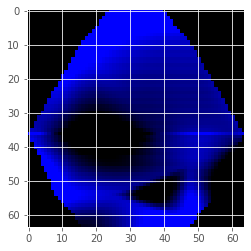

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
zero = np.zeros((64,64,3))
zero[:,:,2] = X[3,:,:,2]
plt.imshow(zero)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


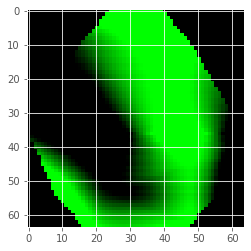

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
zero = np.zeros((64,64,3))
zero[:,:,1] = X[3,:,:,1]
plt.imshow(zero)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


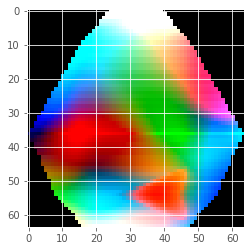

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
zero = np.zeros((64,64,3))
zero[:,:,0] = X[1,:,:,0]
plt.imshow(X[1])

In [ ]:



out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (640,480))

while(True):
    ret, frame = cap.read()
    out.write(frame)
    cv2.imshow('frame', frame)
    c = cv2.waitKey(1)
    if c & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

In [62]:
import cv2


fourcc = cv2.VideoWriter_fourcc('M','P','4','V')
fps = 30
video_filename = 'output.avi'
out = cv2.VideoWriter(video_filename, fourcc, fps, (64, 64))
# fourcc = cv2.cv.CV_FOURCC(*'mp4v')

for f in X:
    gray = cv2.normalize(f, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    gray_3c = cv2.merge([gray, gray, gray])
    out.write(gray_3c)

    out.write(f)
out.release()
cv2.destroyAllWindows() 

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10,shuffle=True)

In [26]:
y_train.shape

(2865,)

In [27]:
# input image dimensions
img_rows, img_cols = 64, 64

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (2865, 64, 64, 3)
2865 train samples
319 test samples


In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = 2
epochs = 200

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 2394 samples, validate on 599 samples
Epoch 1/200
2394/2394 [==============================] - 4s 2ms/step - loss: 0.6978 - accuracy: 0.5175 - val_loss: 0.6888 - val_accuracy: 0.5710
Epoch 2/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6864 - accuracy: 0.5251 - val_loss: 0.6911 - val_accuracy: 0.4925
Epoch 3/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6837 - accuracy: 0.5409 - val_loss: 0.6837 - val_accuracy: 0.5342
Epoch 4/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6813 - accuracy: 0.5455 - val_loss: 0.6836 - val_accuracy: 0.5376
Epoch 5/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6787 - accuracy: 0.5551 - val_loss: 0.6769 - val_accuracy: 0.5843
Epoch 6/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6755 - accuracy: 0.5639 - val_loss: 0.6801 - val_accuracy: 0.5492
Epoch 7/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6739

Epoch 57/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6057 - accuracy: 0.6546 - val_loss: 0.6712 - val_accuracy: 0.5810
Epoch 58/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6029 - accuracy: 0.6571 - val_loss: 0.6724 - val_accuracy: 0.5977
Epoch 59/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6024 - accuracy: 0.6550 - val_loss: 0.6702 - val_accuracy: 0.6060
Epoch 60/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6033 - accuracy: 0.6550 - val_loss: 0.6677 - val_accuracy: 0.6043
Epoch 61/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6035 - accuracy: 0.6579 - val_loss: 0.6669 - val_accuracy: 0.5943
Epoch 62/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6048 - accuracy: 0.6479 - val_loss: 0.6792 - val_accuracy: 0.5726
Epoch 63/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.6000 - accuracy: 0.6558 - val_loss: 0.6700 -

2394/2394 [==============================] - 3s 1ms/step - loss: 0.5502 - accuracy: 0.6942 - val_loss: 0.7044 - val_accuracy: 0.6194
Epoch 114/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5482 - accuracy: 0.6984 - val_loss: 0.6992 - val_accuracy: 0.6093
Epoch 115/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5500 - accuracy: 0.6988 - val_loss: 0.6884 - val_accuracy: 0.5927
Epoch 116/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5523 - accuracy: 0.6892 - val_loss: 0.6829 - val_accuracy: 0.6311
Epoch 117/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5501 - accuracy: 0.6947 - val_loss: 0.6926 - val_accuracy: 0.6144
Epoch 118/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5498 - accuracy: 0.6959 - val_loss: 0.6905 - val_accuracy: 0.6110
Epoch 119/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5494 - accuracy: 0.6917 - val_loss: 0.6855 - val_ac

Epoch 169/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5145 - accuracy: 0.7285 - val_loss: 0.7088 - val_accuracy: 0.6110
Epoch 170/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5138 - accuracy: 0.7310 - val_loss: 0.7076 - val_accuracy: 0.6093
Epoch 171/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5097 - accuracy: 0.7281 - val_loss: 0.7042 - val_accuracy: 0.6244
Epoch 172/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5124 - accuracy: 0.7272 - val_loss: 0.7173 - val_accuracy: 0.5826
Epoch 173/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5104 - accuracy: 0.7293 - val_loss: 0.7128 - val_accuracy: 0.6043
Epoch 174/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5109 - accuracy: 0.7189 - val_loss: 0.7164 - val_accuracy: 0.6160
Epoch 175/200
2394/2394 [==============================] - 3s 1ms/step - loss: 0.5088 - accuracy: 0.7302 - val_loss: 0

In [28]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from resnets_utils import *
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def ResNet50(input_shape = (64, 64, 3), classes = 2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'b')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'c')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'd')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'b')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'c')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'd')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'e')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block = 'b')
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block = 'c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    #X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    X = AveragePooling2D(pool_size = (1, 1), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [29]:
import keras
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
batch_size = 32
num_classes = 2
epochs = 200
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

rn_model = ResNet50(input_shape = (64,64,3), classes = 2)
rn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [30]:
rn_model.fit(x_train, y_train, epochs = 30, batch_size = 32, validation_split = 0.1, verbose  =1 , shuffle=True)

Train on 2578 samples, validate on 287 samples
Epoch 1/30
2578/2578 [==============================] - 56s 22ms/step - loss: 2.3562 - accuracy: 0.5628 - val_loss: 0.7921 - val_accuracy: 0.4634
Epoch 2/30
2578/2578 [==============================] - 42s 16ms/step - loss: 1.6960 - accuracy: 0.5950 - val_loss: 0.7508 - val_accuracy: 0.4634
Epoch 3/30
2578/2578 [==============================] - 42s 16ms/step - loss: 1.3315 - accuracy: 0.6078 - val_loss: 0.7076 - val_accuracy: 0.4878
Epoch 4/30
2578/2578 [==============================] - 42s 16ms/step - loss: 1.1657 - accuracy: 0.6427 - val_loss: 1.1747 - val_accuracy: 0.5366
Epoch 5/30
2578/2578 [==============================] - 42s 16ms/step - loss: 0.9344 - accuracy: 0.6947 - val_loss: 0.9761 - val_accuracy: 0.5993
Epoch 6/30
2578/2578 [==============================] - 42s 16ms/step - loss: 0.6930 - accuracy: 0.7219 - val_loss: 0.7123 - val_accuracy: 0.7038
Epoch 7/30
2578/2578 [==============================] - 42s 16ms/step - loss:

KeyboardInterrupt: 